In [23]:
import finsight_rag.config as config
from finsight_rag.utils import load_yaml
import seaborn as sns
from matplotlib import pyplot as plt
from importlib import resources as impresources

sentiment_cfg_path = (impresources.files(config) / "sentiment_analyser_config.yaml")
sentiment_cfg = load_yaml(sentiment_cfg_path)

print("Sentiment Analysis Model\n")
for key, value in sentiment_cfg["model"].items():
    print(f"{key}: {value}")
    
training_cfg = sentiment_cfg["training"]
print("\nTraining Configuration\n")
for key, value in training_cfg.items():
    print(f"{key}: {value}")

Sentiment Analysis Model

pretrained_name: distilbert-base-uncased
max_length: 256

Training Configuration

output_dir: models/sentiment_distilbert_phrasebank
overwrite_output_dir: True
num_train_epochs: 3
learning_rate: 2e-05
weight_decay: 0.01
per_device_train_batch_size: 4
per_device_eval_batch_size: 8
gradient_accumulation_steps: 4
warmup_ratio: 0.06
logging_steps: 25
eval_strategy: epoch
save_strategy: epoch
save_total_limit: 2
load_best_model_at_end: True
metric_for_best_model: f1_macro
greater_is_better: True


## Examples of Predictions

In [4]:
from finsight_rag.sentiment.sentiment_analysis_service import SentimentAnalysisService

sentiment_analysis_service = SentimentAnalysisService(sentiment_cfg)

In [5]:
sentiment_analysis_service.predict("The company has stable revenues, nothing exciting.")

{'label': 'neutral',
 'score': 0.8366780877113342,
 'scores': [{'label': 'neutral', 'score': 0.8366780877113342},
  {'label': 'positive', 'score': 0.14343921840190887},
  {'label': 'negative', 'score': 0.01988275907933712}]}

In [6]:
sentiment_analysis_service.predict("The company did not achieve higher revenues.")

{'label': 'negative',
 'score': 0.9333619475364685,
 'scores': [{'label': 'negative', 'score': 0.9333619475364685},
  {'label': 'positive', 'score': 0.042153965681791306},
  {'label': 'neutral', 'score': 0.02448401413857937}]}

In [7]:
sentiment_analysis_service.predict("The company achieved higher revenues.")

{'label': 'positive',
 'score': 0.9771595597267151,
 'scores': [{'label': 'positive', 'score': 0.9771595597267151},
  {'label': 'negative', 'score': 0.014094162732362747},
  {'label': 'neutral', 'score': 0.008746316656470299}]}

In [8]:
sentiment_analysis_service.predict("The company had no significant growth in this quarter.")

{'label': 'negative',
 'score': 0.9064146876335144,
 'scores': [{'label': 'negative', 'score': 0.9064146876335144},
  {'label': 'positive', 'score': 0.051120586693286896},
  {'label': 'neutral', 'score': 0.04246469587087631}]}

In [9]:
sentiment_analysis_service.predict("The company had significant growth in this quarter.")

{'label': 'positive',
 'score': 0.9807952046394348,
 'scores': [{'label': 'positive', 'score': 0.9807952046394348},
  {'label': 'negative', 'score': 0.009828616864979267},
  {'label': 'neutral', 'score': 0.009376160800457}]}

## Model Metrics

In [13]:
from importlib import resources as impresources
import json
import finsight_rag

model_dir = training_cfg["output_dir"]
model_absolute_path = str(impresources.files(finsight_rag) / ".." / model_dir)


with open(f"{model_absolute_path}/test_metrics.json", "r") as f:
    test_metrics = json.load(f)

print("Test Metrics:")
for key, value in test_metrics.items():
    print(f"{key}: {value}")

Test Metrics:
test_loss: 0.14486975967884064
test_accuracy: 0.947136563876652
test_f1_macro: 0.9250151978243114
test_runtime: 7.1291
test_samples_per_second: 31.841
test_steps_per_second: 4.068
epoch: 3.0


In [14]:
checkpoint_dir = model_absolute_path + "/checkpoint-342"
with open(f"{checkpoint_dir}/trainer_state.json", "r") as f:
    checkpoint_trainer_state = json.load(f)

log_history = checkpoint_trainer_state["log_history"]

In [27]:
import pandas as pd

df_log_history = pd.DataFrame(log_history)
print("\nLog History DataFrame:")
df_log_history.head()


Log History DataFrame:


,epoch,grad_norm,learning_rate,loss,step,eval_accuracy,eval_f1_macro,eval_loss,eval_runtime,eval_samples_per_second,eval_steps_per_second
0,0.220751,1.579454,0.000020,1.0407,25,NaN,NaN,NaN,NaN,NaN,NaN
1,0.441501,4.531241,0.000018,0.7345,50,NaN,NaN,NaN,NaN,NaN,NaN
2,0.662252,5.098536,0.000017,0.5286,75,NaN,NaN,NaN,NaN,NaN,NaN
3,0.883002,3.748757,0.000015,0.3851,100,NaN,NaN,NaN,NaN,NaN,NaN
4,1.000000,NaN,NaN,NaN,114,0.915929,0.87695,0.269934,7.0547,32.035,4.111


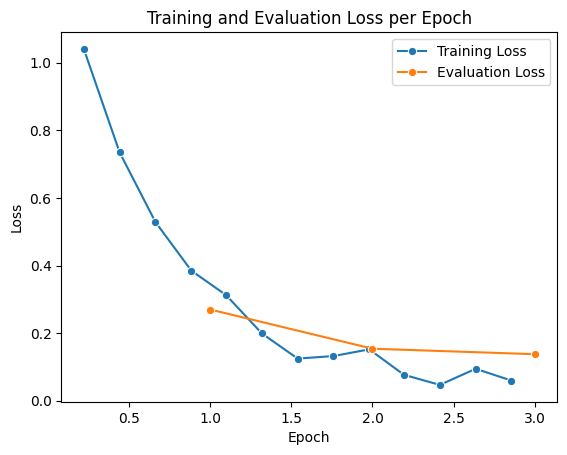

In [24]:
loss_per_epoch = df_log_history[df_log_history["loss"].notna()][["epoch", "loss"]]
eval_loss_per_epoch = df_log_history[df_log_history["eval_loss"].notna()][["epoch", "eval_loss"]]

ax = sns.lineplot(data=loss_per_epoch, x="epoch", y="loss", marker="o", label="Training Loss")
sns.lineplot(data=eval_loss_per_epoch, x="epoch", y="eval_loss", marker="o", label="Evaluation Loss", ax=ax)
ax.set_title("Training and Evaluation Loss per Epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.legend()

plt.show()

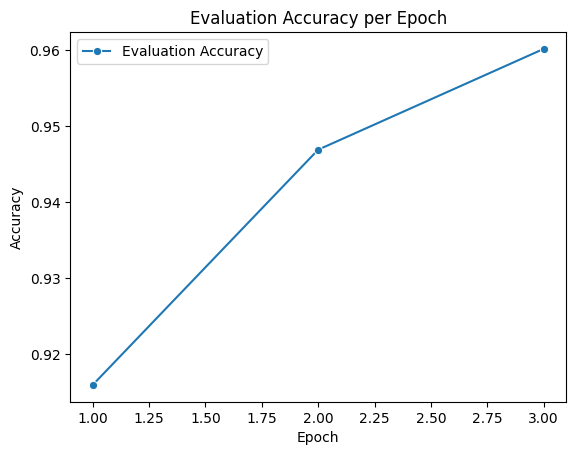

In [25]:
eval_accuracy_per_epoch = df_log_history[df_log_history["eval_accuracy"].notna()][["epoch", "eval_accuracy"]]

ax = sns.lineplot(data=eval_accuracy_per_epoch, x="epoch", y="eval_accuracy", marker="o", label="Evaluation Accuracy")
ax.set_title("Evaluation Accuracy per Epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("Accuracy")
ax.legend()
plt.show()

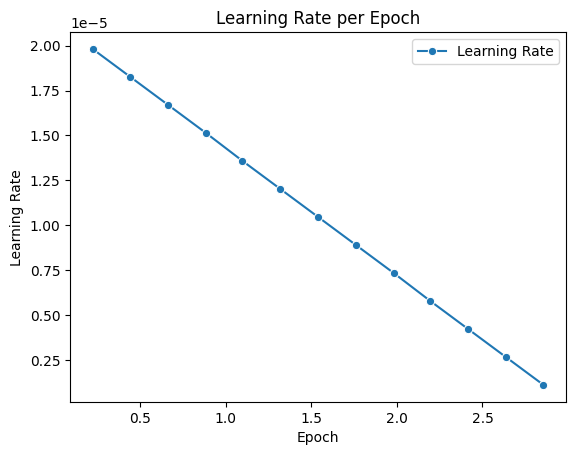

In [26]:
lr_rate_per_epoch = df_log_history[df_log_history["learning_rate"].notna()][["epoch", "learning_rate"]]

ax = sns.lineplot(data=lr_rate_per_epoch, x="epoch", y="learning_rate", marker="o", label="Learning Rate")
ax.set_title("Learning Rate per Epoch")
ax.set_xlabel("Epoch")
ax.set_ylabel("Learning Rate")
ax.legend()
plt.show()